# **Генерация подписей к изображениям (baseline)**

## Импорт библиотек

In [1]:
import os
import random
import pandas as pd  
import spacy  # для токенизатора
import torch
from torch.nn.utils.rnn import pad_sequence  
from torch.utils.data import DataLoader, Dataset
from PIL import Image  
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.optim as optim
import statistics
import torchvision.models as models

from tqdm import tqdm
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

## Эмбэддинг слов

*Мы хотим преобразовать текст в числовые значения*
1. Нам нужен словарь, сопоставляющий каждое слово индексу
2. Нам нужно настроить набор данных Pytorch для загрузки данных
3. Настройка заполнения каждого батча (все предложения должны быть одной длины)

In [2]:
spacy_eng = spacy.load("en_core_web_sm")

***Токенезация предложений*** 

Токенезация = векторизация

Помимо эмбеддинга слов в вектора, используют специальные токены:

* `PAD` - используется для выравни вания предложений, если предложение больше установленной длины, слова обрезаются, если меньше - в предложение добавляется pad стольео раз, пока длина не достигнет необходимого значения

* `SOS` - "start of sentence" то же, что и <start> на картинке ниже - первый токен, который подается в декодер вместе с вектором, чтобы начать генерировать токены ответа
* `EOS` - "end of sentence" - то же, что и <end> на картинке ниже - как только декодер сгенерирует этот токен, мы считаем ответ полным (обычные знаки препинания для этой цели использовать нельзя, так как их значениея могут быть разные)

* `UNK` - "unknown token" - используется для замены редких слов, которые не вошли к ваш словарь. Например, предложение «Меня зовут guotong1999» будет переведено на «Меня зовут _unk_»

<img src='https://cloud.githubusercontent.com/assets/2272790/18410099/1d0a1c1a-7761-11e6-9fe1-bd2e5622b90a.png'>

In [3]:
# Создание словаря
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

##  Flickr8k датасет

In [4]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform

        # Сохраняем картинку и описание
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

        # Создаем словарь
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)



# Приводим описание картинок и их эмбеддинги к общему виду
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets


def get_loader(
    root_folder,
    annotation_file,
    transform,
    batch_size=32,
    num_workers=os.cpu_count(),
    shuffle=True,
    pin_memory=True,
):
    dataset = FlickrDataset(root_folder, annotation_file, transform=transform)

    pad_idx = dataset.vocab.stoi["<PAD>"]

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    )

    return loader, dataset

In [5]:
imgs_path = "/kaggle/input/flickr8k/Images"
cptns_file = "/kaggle/input/flickr8k/captions.txt"

In [6]:
transform = transforms.Compose(
        [transforms.Resize((224, 224)), transforms.ToTensor(),]
    )

loader, dataset = get_loader(imgs_path , cptns_file, transform=transform)

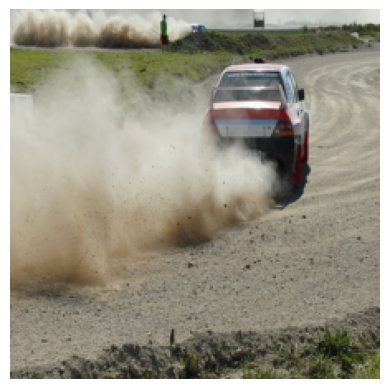

case idx: 31785
caption:
<SOS> a car is driven on a dusty track . <EOS>


In [7]:
# Случайно выбираем индекс
random_index = random.randint(0, len(dataset) - 1)

# Получаем изображение и подпись
img, caption = dataset[random_index]

# Преобразуем тензор изображения обратно в numpy массив для отображения
img = img.permute(1, 2, 0).numpy()
img = ((img - img.min()) / (img.max() - img.min()) * 255).astype('uint8')

# Декодируем подпись
caption_words = [dataset.vocab.itos[idx.item()] for idx in caption]
caption_text = ' '.join(caption_words)

# Отображаем изображение и подпись
plt.imshow(img)
plt.axis('off')
plt.show()

print(
    f'case idx: {random_index}',
    f'caption:\n{caption_text}',
    sep='\n'
)

## Модель

Модель подписей к изображениям состоит из кодировщика и декодера. В качестве кодировщика выступает линейный слой, который используется сразу после предобученной ***CNN***. Декодера - ***RNN***. 

<img src='https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png'>

In [8]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN
        # Загрузка предобученной CNN модели
        self.inception = models.inception_v3(weights="IMAGENET1K_V1")
        # Замена последнего слоя-классификатора на эмбеддер
        self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.times = []
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        outputs = self.inception(images)
        
        if len(outputs) == 2:
            features = outputs[0]
        else:
            features = outputs
        
        return self.dropout(self.relu(features))


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs


class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

        return [vocabulary.itos[idx] for idx in result_caption]

In [9]:
def visualizer(model, dataset, device):
    model.eval()
    with torch.no_grad():
        # Выбираем случайное изображение из валидационного набора
        val_img, val_caption = random.choice(dataset)
        val_img = val_img.unsqueeze(0).to(device)

        # Генерируем подпись
        generated_caption = model.caption_image(val_img, dataset.vocab)
        decoded_caption = " ".join(generated_caption)

        # Визуализируем изображение и его подпись
        img = val_img.squeeze(0).cpu().numpy().transpose(1, 2, 0)
        img = (img - img.min()) / (img.max() - img.min())

        plt.figure(figsize=(10, 5))
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        
        print('predict:', decoded_caption)
        val_caption_words = [dataset.vocab.itos[idx.item()] for idx in val_caption]
        print(f'true: {" ".join(val_caption_words)}')

## Обучение модели

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 165MB/s] 


Epoch [1/10], avg train loss: 3.3204


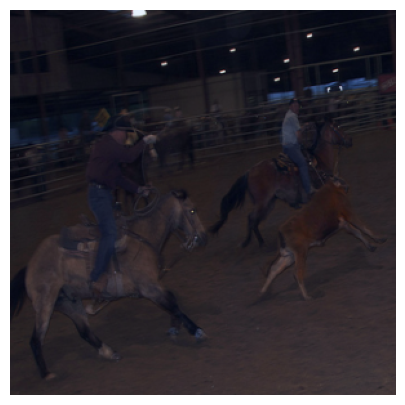

predict: <SOS> a man in a black shirt is standing on a bench . <EOS>
true: <SOS> two people on horses chasing cow in an arena . <EOS>


Epoch [2/10], avg train loss: 2.7195


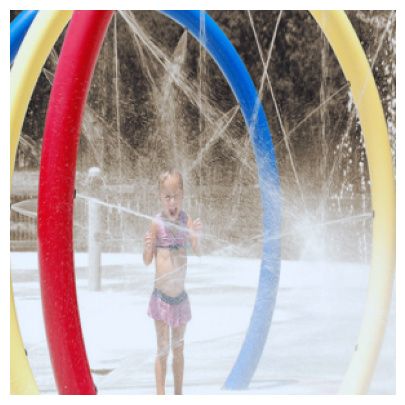

predict: <SOS> a boy in a red shirt is riding a bike on a dirt bike . <EOS>
true: <SOS> colorful rings spraying water at little girl wearing swimsuit . <EOS>


Epoch [3/10], avg train loss: 2.5052


Epoch [4/10], avg train loss: 2.3660


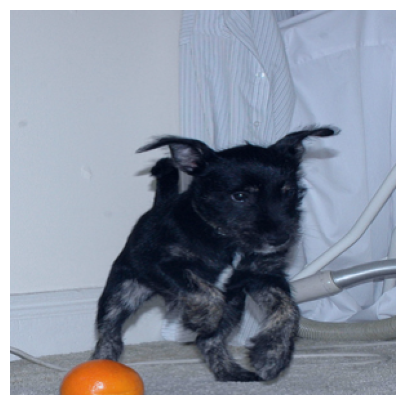

predict: <SOS> a black dog is running through a field . <EOS>
true: <SOS> an orange on the floor next to a dog . <EOS>


Epoch [5/10], avg train loss: 2.2549


Epoch [6/10], avg train loss: 2.1603


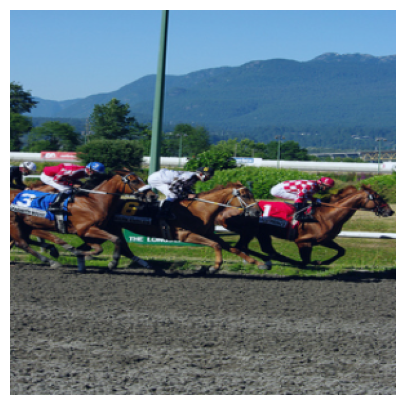

predict: <SOS> a man in a red jacket is riding a bicycle down a dirt path . <EOS>
true: <SOS> three horses and their jockeys compete in a race . <EOS>


Epoch [7/10], avg train loss: 2.0752


Epoch [8/10], avg train loss: 1.9969


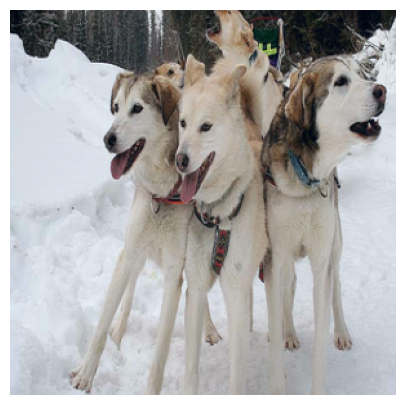

predict: <SOS> a group of dogs pulling a sled through the snow . <EOS>
true: <SOS> pack of sled dogs in the snow , one barking . <EOS>


Epoch [9/10], avg train loss: 1.9240


Epoch [10/10], avg train loss: 1.8521


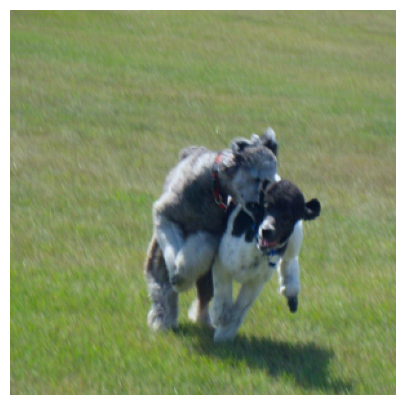

predict: <SOS> a black and white dog is running through the grass . <EOS>
true: <SOS> two dogs wrestle in a field . <EOS>


In [10]:
def train():
    transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize(
                (0.485, 0.456, 0.406),
                (0.229, 0.224, 0.225)
            )
        ]
    )

    train_loader, dataset = get_loader(
        root_folder=imgs_path,
        annotation_file=cptns_file,
        transform=transform
    )

    torch.backends.cudnn.benchmark = True
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_CNN = False

    # Гиперпараметры
    embed_size = 1024
    hidden_size = 1024
    vocab_size = len(dataset.vocab)
    num_layers = 2
    learning_rate = 3e-4
    num_epochs = 10
    rep_freq = 2


    # Инициализация
    model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Только тонкая настройка CNN
    for name, param in model.encoderCNN.inception.named_parameters():
        if "fc.weight" in name or "fc.bias" in name:
            param.requires_grad = True
        else:
            param.requires_grad = train_CNN
    
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for idx, (imgs, captions) in tqdm(
            enumerate(train_loader), total=len(train_loader), leave=False
        ):
            imgs = imgs.to(device)
            captions = captions.to(device)

            outputs = model(imgs, captions[:-1])
            loss = criterion(
                outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
            )

            optimizer.zero_grad()
            loss.backward(loss)
            optimizer.step()

            total_train_loss += loss.item()
            
        avg_train_loss = total_train_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], avg train loss: {avg_train_loss:.4f}")
        
        # Визуализация результатов
        if (epoch == 0) or ((epoch + 1) % rep_freq == 0):
            visualizer(model, dataset, device)
        
    return model


model = train()

## Инференс

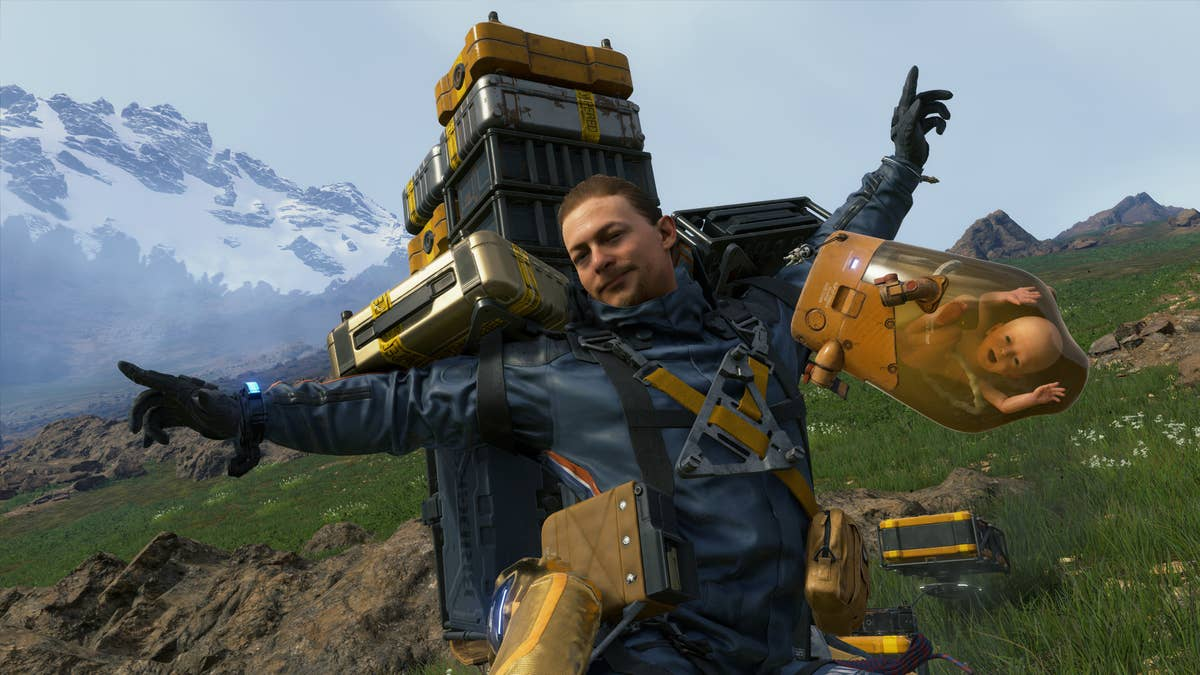

<SOS> a man is jumping over a large rock in the middle of a city . <EOS>


In [11]:
import requests
from PIL import Image 

def load_image_from_url(url):
    # Получение изображения по URL
    response = requests.get(url, stream=True)
    response.raise_for_status()
    image = Image.open(response.raw).convert('RGB')
    return image

# URL изображения
image_url = 'https://assetsio.gnwcdn.com/death-stranding-mountain-jump.jpg?width=1200&height=1200&fit=bounds&quality=70&format=jpg&auto=webp'

# Загрузка изображения
image = load_image_from_url(image_url)

# Применение трансформаций
image_tf = transform(image)

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Добавление размера пакета
image_tf_b = image_tf.unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    # Генерируем подпись
    generated_caption = model.caption_image(image_tf_b, dataset.vocab)
    decoded_caption = " ".join(generated_caption)
    display(image)
    print(decoded_caption)

А как начинал-то...

Но даже такой результат для меня выше ожиданий — их у меня вовсе не было к модели, о динамике обучения которого я не могу судить обоснованно. Валидации нет, тексты подписей не обработаны. Более обстоятельно эту задачу я рассмотрю в другой тетрадке.